## Download data from datasets :

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import fasttext
import re
import string
from string import digits
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# download the dataset using run,py
# use datasets library for downloading


from datasets import load_dataset
raw_datasets = load_dataset("./run.py",  "raw_datasets", split="train")

Found cached dataset run (/home/cgiuser/.cache/huggingface/datasets/run/raw_datasets/0.0.0/2cae6c9928007a851cc344dbeef11917d3313fc7890d64b041624cabd5a73db3)


In [3]:
# pip install datasets

In [4]:
# raw view of data in dataset

raw_datasets[2]

{'id': '2',
 'source': 'ted',
 'alignment_type': '1-1',
 'alignment_quality': '1.0',
 'translation': {'en': "I'd like to tell you about one such child,",
  'hi': 'मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,'}}

## Data preperation :

In [5]:
# create a dataframe using raw data in dataset.

final_lst = []

for trans in tqdm(raw_datasets):
    eng = trans['translation']['en']
    hi = trans['translation']['hi']
    final_lst.append([eng,hi])
    
trans_data = pd.DataFrame(final_lst,columns=['eng_sent','hi_sent'])



100%|██████████| 273885/273885 [00:13<00:00, 20936.37it/s]


In [6]:
# glimpse of dataframe

trans_data.sample(2)

,eng_sent,hi_sent
140505,people we're analyzing are based?,हम का विश्लेषण कर रहे हैं लोगों के लिए कर रहे ...
118346,And I was astounded to hear the little fellow ...,इस बच्चे का जवाब सुनकर तो मैं अवाक् रह गया -


In [7]:
# glimpse of translation

print('English sentence: ',trans_data['eng_sent'].iloc[1])
print('*'*100)
print('Hindi sentence: ',trans_data['hi_sent'].iloc[1])

English sentence:  politicians do not have permission to do what needs to be done.
****************************************************************************************************
Hindi sentence:  राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है .


## Data pre-processing :

In [8]:
# pip install fasttext

In [9]:
# we can use fasttext to identify the language
# https://fasttext.cc/docs/en/language-identification.html
# download the model from given path


!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2023-10-26 04:37:34--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.202.10, 18.164.202.35, 18.164.202.120, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.202.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz.5’

lid.176.ftz.5       100%[===================>] 916.03K  4.91MB/s    in 0.2s    

2023-10-26 04:37:34 (4.91 MB/s) - ‘lid.176.ftz.5’ saved [938013/938013]



In [10]:
# import fasttext and predict using model loaded.




model = fasttext.load_model('lid.176.ftz')
print(model.predict('राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है', k=1))  # top 2 matching languages

(('__label__hi',), array([0.97123677]))


In [11]:
# check for any null values

trans_data.isnull().sum()

eng_sent    0
hi_sent     0
dtype: int64

### Data cleaning :

In [12]:


# Lowercase all characters
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: x.lower())

trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"won\'t", "will not", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"can\'t", "can not", x))

# general
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"n\'t", " not", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'re", " are", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'s", " is", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'d", " would", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'ll", " will", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'t", " not", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'ve", " have", x))
trans_data['eng_sent'] = trans_data['eng_sent'].apply(lambda x: re.sub(r"\'m", " am", x))

# Remove quotes
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: re.sub("'", '', x))
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: re.sub("'", '', x))


exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: x.translate(remove_digits))
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: x.translate(remove_digits))

trans_data['hi_sent'] = trans_data['hi_sent'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
# if eng_sent text in hi_sent column
trans_data['hi_sent'] = trans_data['hi_sent'].apply(lambda x: re.sub("[A-Za-z]", "", x))

# remove extra
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: re.sub('[-_.:;\[\]\|,]', '', x))
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: re.sub('[-_.;\[\]\|,]', '', x))

# Remove extra spaces
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: x.strip())
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: x.strip())
trans_data['eng_sent']=trans_data['eng_sent'].apply(lambda x: re.sub(" +", " ", x))
trans_data['hi_sent']=trans_data['hi_sent'].apply(lambda x: re.sub(" +", " ", x))

In [13]:
# glimpse of translation

print('English sentence: ',trans_data['eng_sent'].iloc[2])
print('*'*100)
print('Hindi sentence: ',trans_data['hi_sent'].iloc[2])

English sentence:  i would like to tell you about one such child
****************************************************************************************************
Hindi sentence:  मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी


In [14]:
trans_data.head(2)

,eng_sent,hi_sent
0,sharaabi,शराबी
1,politicians do not have permission to do what ...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...


### Check language of text

In [15]:
# we predict language type using fasttext
# then match with given lang
# if not matchinhg then we remove those rows

trans_data['is_hi_sent'] = True
trans_data['is_eng_sent'] = True

error = []
count = 0
for i,row in tqdm(trans_data.iterrows()):
    hi_tex = trans_data.iloc[i]['hi_sent']
    en_tex = trans_data.iloc[i]['eng_sent']
    try:
        hin_pred = model.predict(hi_tex,k=3)[0]
        if set(['__label__hi']).issubset(hin_pred) or set(['__label__mr']).issubset(hin_pred):
            pass
        else:
            trans_data.at[i,'is_hi_sent'] = False
            count += 1
        en_pred = model.predict(en_tex,k=3)[0]
        if set(['__label__en']).issubset(en_pred):
            pass
        else:
            trans_data.at[i,'is_eng_sent'] = False
            count += 1
    except:
        error.append(i)

273885it [01:07, 4072.19it/s]


In [16]:
print('Where sent is not in english : ',trans_data[trans_data.is_eng_sent == False].shape[0])
print("*"*100)
print('Where sent is not in hindi : ',trans_data[trans_data.is_hi_sent == False].shape[0])

Where sent is not in english :  7998
****************************************************************************************************
Where sent is not in hindi :  5132


In [17]:
# remove the data where it is not matching

trans_data = trans_data[~trans_data.is_hi_sent == False]
trans_data = trans_data[~trans_data.is_eng_sent == False]


print('After removing not matching data :',trans_data.shape[0])

After removing not matching data : 261117


In [18]:
# drop unnecessary columns

trans_data.drop(columns=['is_hi_sent','is_eng_sent'],inplace=True)

## Data analysis :

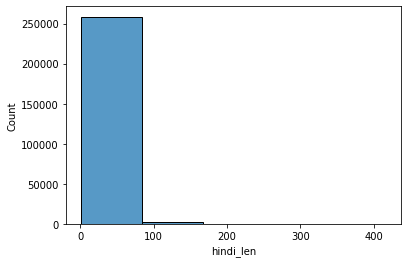

In [19]:


trans_data['hindi_len'] = trans_data['hi_sent'].apply(lambda x: len(x.split()))
trans_data['english_len'] = trans_data['eng_sent'].apply(lambda x: len(x.split()))

sns.histplot(trans_data.hindi_len, bins=5)
plt.show()

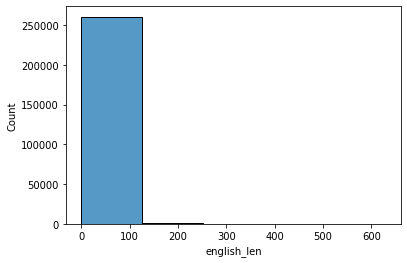

In [20]:
sns.histplot(trans_data.english_len, bins=5)
plt.show()

In [21]:
# we can identify the length of text in percentile
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(trans_data.hindi_len, i)))

10 Quantile is 1.0
20 Quantile is 2.0
30 Quantile is 3.0
40 Quantile is 5.0
50 Quantile is 8.0
60 Quantile is 11.0
70 Quantile is 15.0
80 Quantile is 20.0
90 Quantile is 30.0
100 Quantile is 416.0


In [22]:
# hindi
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(trans_data.hindi_len, i)))

90 Quantile is 30.0
91 Quantile is 31.0
92 Quantile is 33.0
93 Quantile is 35.0
94 Quantile is 38.0
95 Quantile is 41.0
96 Quantile is 45.0
97 Quantile is 51.0
98 Quantile is 61.0
99 Quantile is 82.0
100 Quantile is 416.0


In [23]:
# we can identify the length of text in percentile
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(trans_data.english_len, i)))

10 Quantile is 1.0
20 Quantile is 2.0
30 Quantile is 3.0
40 Quantile is 5.0
50 Quantile is 7.0
60 Quantile is 10.0
70 Quantile is 13.0
80 Quantile is 18.0
90 Quantile is 27.0
100 Quantile is 629.0


In [24]:
# englist sent
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(trans_data.english_len, i)))

90 Quantile is 27.0
91 Quantile is 29.0
92 Quantile is 31.0
93 Quantile is 32.0
94 Quantile is 35.0
95 Quantile is 38.0
96 Quantile is 42.0
97 Quantile is 49.0
98 Quantile is 59.0
99 Quantile is 81.84000000002561
100 Quantile is 629.0


In [25]:
# we can limit len of sentence to 40

trans_data = trans_data[trans_data.english_len<=40]
trans_data = trans_data[trans_data.hindi_len<=40]

print('Final rows of data : ',trans_data.shape[0])

Final rows of data :  245937


## Model :

In [26]:
# we create decoder input and decoder output
# for decoder input we have to add start string in start of sent
# for decoder output we have to add end string in end of sent

trans_data['hi_inp'] = '<start> ' + trans_data.hi_sent 
trans_data['hi_out'] = trans_data.hi_sent + ' <end>' 

In [27]:
# drop unnecessary columns

trans_data.drop(columns=['english_len','hindi_len', 'hi_sent'],inplace=True)

trans_data.head(2)

,eng_sent,hi_inp,hi_out
0,sharaabi,<start> शराबी,शराबी <end>
1,politicians do not have permission to do what ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...


In [28]:
trans_data.to_csv('train_data.csv')

In [29]:
import pandas as pd

data = pd.read_csv('train_data.csv')

In [30]:
data.head(2)

,Unnamed: 0,eng_sent,hi_inp,hi_out
0,0,sharaabi,<start> शराबी,शराबी <end>
1,1,politicians do not have permission to do what ...,<start> राजनीतिज्ञों के पास जो कार्य करना चाहि...,राजनीतिज्ञों के पास जो कार्य करना चाहिए वह करन...


In [31]:
# split dataset


from sklearn.model_selection import train_test_split
train, validation = train_test_split(trans_data, test_size=0.2, random_state=42)

In [32]:
print('Number of rows in train data : ',train.shape[0])
print("*"*100)
print('Number of rows in validation data : ',validation.shape[0])

Number of rows in train data :  196749
****************************************************************************************************
Number of rows in validation data :  49188


In [33]:
# add <end> in first row so we can use same tokenizer for both hi_inp and eng_out
train.hi_inp.iloc[0]= str(train.hi_inp.iloc[0]) + ' <end>'

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization on data
token_eng = Tokenizer()
token_eng.fit_on_texts(train['eng_sent'].values)
token_hi = Tokenizer(filters='')
token_hi.fit_on_texts(train['hi_inp'].values)

In [35]:
vocab_size_eng=len(token_eng.word_index.keys())
print('Vocab size of english is',vocab_size_eng)
print("*"*100)
vocab_size_hi=len(token_hi.word_index.keys())
print('Vocab size of hindi is',vocab_size_hi)

Vocab size of english is 76357
****************************************************************************************************
Vocab size of hindi is 87591


In [36]:
token_hi.word_index['<start>'], token_hi.word_index['<end>']

(1, 48906)

In [37]:
# convert text to numbers

max_len = 40
# test to sequence
train_dec_in = token_hi.texts_to_sequences(train.hi_inp)
train_dec_out = token_hi.texts_to_sequences(train.hi_out)
train_eng_inp = token_eng.texts_to_sequences(train.eng_sent)

# padding
train_dec_in_seq = pad_sequences(train_dec_in, maxlen=max_len, padding='post', dtype='int32')
train_dec_out_seq = pad_sequences(train_dec_out, maxlen=max_len, padding='post', dtype='int32')
train_eng_inp_seq = pad_sequences(train_eng_inp, maxlen=max_len, padding='post', dtype='int32')

# test to sequence
test_dec_in = token_hi.texts_to_sequences(validation.hi_inp)
test_dec_out = token_hi.texts_to_sequences(validation.hi_out)
test_eng_inp = token_eng.texts_to_sequences(validation.eng_sent)

# padding
test_dec_in_seq = pad_sequences(test_dec_in, maxlen=max_len, padding='post', dtype='int32')
test_dec_out_seq = pad_sequences(test_dec_out, maxlen=max_len, padding='post', dtype='int32')
test_eng_inp_seq = pad_sequences(test_eng_inp, maxlen=max_len, padding='post', dtype='int32')

In [38]:
# check how vectorization has been done

index = 4
print('Encoder text :',train.eng_sent.iloc[index])
print('Representation :',train_eng_inp_seq[index])

print('hi text :', train.hi_inp.iloc[index])
print('Decoder input :',train_dec_in_seq[index])

print('Decoder output :',train.hi_out.iloc[index])
print('Decoder output :',train_dec_out_seq[index])

Encoder text : templatebharat ratna
Representation : [27575  6846     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
hi text : <start> साँचाभारत रत्न सम्मानित
Decoder input : [    1 26268  2992  2210     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]
Decoder output : साँचाभारत रत्न सम्मानित <end>
Decoder output : [26268  2992  2210 48906     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [39]:
len(train_eng_inp_seq)

196749

In [40]:
# create a dictionaries from num to word and vice versa
hi_index_word = {}
hi_word_index = {}

for key, value in token_hi.word_index.items():
    hi_index_word[value] = key
    hi_word_index[key] = value

In [41]:
hi_vocab_size = len(token_hi.word_index)+1
eng_vocab_size = len(token_eng.word_index)+1

enc_input_length, dec_input_length, dec_out_length = 40,40,40

###  Encoder - Decoder Seq-Seq model

In [42]:
# reference : https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

def data_generator(encoder_inp, decoder_inp, decoder_out, batch_size):
    '''
    Data Generator for model training
    It returns list of encoder_imput and decoder_input of each shape [batch_size, max_len]
    and decoder_out of shape (batch_size, max_len)
    '''
    while True:
        for i in range(0, len(encoder_inp), batch_size):
            # creating empty matrix
            enc_inp_batch = np.zeros(shape = (batch_size, encoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_inp_batch = np.zeros(shape = (batch_size, decoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_out_batch = np.zeros(shape = (batch_size, decoder_out.shape[-1])) # shape = (batch_size, max_len)
            for j in range(batch_size):
                if (i+j) < len(encoder_inp):
                    # adding batch wise values
                    enc_inp_batch[j] = encoder_inp[i+j]
                    dec_inp_batch[j] = decoder_inp[i+j]
                    dec_out_batch[j] = decoder_out[i+j]
            # Yield is a keyword in Python that is used to return from a function without 
            # destroying the states of its local variable and when the function is called, 
            # the execution starts from the last yield statement.
            yield [enc_inp_batch, dec_inp_batch], dec_out_batch

In [43]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, RNN, LSTMCell, Activation, add, concatenate
from tensorflow.keras.models import Model

In [44]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length = input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences = True, return_state = True)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          returns -- encoder_output, last time step's hidden and cell state
        '''
        embeddings = self.embedding(input_sequence)
        
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.lstm(embeddings, initial_state = states)
        
        return encoder_output, encoder_final_state_h, encoder_final_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      '''
      return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [45]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.embed_layer = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length)
        #Intialize Decoder LSTM layer
        lstmcell = LSTMCell(lstm_size)
        self.lstm_layer = RNN(lstmcell, return_sequences=True, return_state=True)


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        x = self.embed_layer(input_sequence)
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.lstm_layer(x, initial_state = initial_states)
        return decoder_output,decoder_final_state_h,decoder_final_state_c

In [46]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, ita_vocab_size, eng_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length):
        super().__init__()
        #Create encoder object
        self.encode_obj = Encoder(ita_vocab_size,enc_embedding_size,lstm_size,enc_input_length)
        #Create decoder object
        self.decode_obj = Decoder(eng_vocab_size,dec_embedding_size,lstm_size,dec_input_length)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(eng_vocab_size, activation='softmax')
        self.enc_input_length = enc_input_length
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        enc_data = data[0]
        dec_data = data[1]

        # A
        enc_initial_state = self.encode_obj.initialize_states(tf.shape(enc_data)[0])
        enc_out, enc_h, enc_c = self.encode_obj(enc_data,enc_initial_state)

        # B
        dec_out, dec_h, dec_c = self.decode_obj(dec_data, [enc_h, enc_c])
        # C
        x = self.dense(dec_out)
        return x

In [47]:
enc_embedding_size = 64
dec_embedding_size = 64 
lstm_size = 128

# defining model
en_hi_model = Encoder_decoder(eng_vocab_size, hi_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length)

In [63]:
# model compile
en_hi_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')

from tensorflow.keras.callbacks import EarlyStopping 

# call back of tensorboard

early_stop = EarlyStopping(monitor='val_loss', patience=5)
callback = [early_stop]

In [49]:
batch_size = 108
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# train model
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

2023-10-26 04:39:06.813330: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


Epoch 1/10
4601/7026 [==================>...........] - ETA: 6:12 - loss: 1.9458

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7026/7026 [==============================] - 1401s 199ms/step - loss: 1.5289 - val_loss: 1.4229
Epoch 3/10
7026/7026 [==============================] - 1401s 199ms/step - loss: 1.3616 - val_loss: 1.3300
Epoch 4/10
7026/7026 [==============================] - 1400s 199ms/step - loss: 1.2328 - val_loss: 1.2728
Epoch 5/10
7026/7026 [==============================] - 1404s 200ms/step - loss: 1.1293 - val_loss: 1.2364
Epoch 6/10
7026/7026 [==============================] - 1403s 200ms/step - loss: 1.0448 - val_loss: 1.2152
Epoch 7/10
7026/7026 [==============================] - 1402s 200ms/step - loss: 0.9748 - val_loss: 1.2019
Epoch 8/10
3325/7026 [=============>................] - ETA: 9:28 - loss: 0.9269

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3030/7026 [===========>..................] - ETA: 10:13 - loss: 0.8294

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7026/7026 [==============================] - 1398s 199ms/step - loss: 0.8244 - val_loss: 1.1960


In [59]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
7026/7026 [==============================] - 1403s 200ms/step - loss: 0.7885 - val_loss: 1.2001
Epoch 2/10
7026/7026 [==============================] - 1401s 199ms/step - loss: 0.7576 - val_loss: 1.2055
Epoch 3/10
7026/7026 [==============================] - 1401s 199ms/step - loss: 0.7308 - val_loss: 1.2118
Epoch 4/10
7026/7026 [==============================] - 1402s 200ms/step - loss: 0.7074 - val_loss: 1.2192


In [ ]:
batch_size = 108

en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
1821/1821 [==============================] - 362s 199ms/step - loss: 0.6976 - val_loss: 1.2254
Epoch 2/10
1821/1821 [==============================] - 362s 199ms/step - loss: 0.7178 - val_loss: 1.2291
Epoch 3/10
1821/1821 [==============================] - 362s 199ms/step - loss: 0.7195 - val_loss: 1.2244
Epoch 4/10
1821/1821 [==============================] - 362s 199ms/step - loss: 0.7080 - val_loss: 1.2373
Epoch 5/10
1177/1821 [==================>...........] - ETA: 1:38 - loss: 0.6643

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1808/1821 [============================>.] - ETA: 1s - loss: 0.6879

In [58]:
# # save best model for further use

# en_hi_model.save_weights('model_train_26_10.h5') 

In [51]:
# new_model  = en_hi_model.load_weights('model_train_latest.h5')

### Model evaluation :

In [60]:
# reference: query resolution aaic team 
def predict(input_sentence):
    
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predicted_out,state_h,state_c=model.layers[1](dec_input,states)
            pass the predicted_out to the dense layer
            update the states=[state_h,state_c]
            And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
            Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    # A
    # lets tokenize the sentence first
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post', dtype='int32')
    
    # B
    # get the initial encoder states
    enc_init_states = en_hi_model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = en_hi_model.layers[0](encoder_input, states = enc_init_states)

    # C
    decoder_initial_states = [enc_h_state, enc_c_state]
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D
    predicted_words = []
    predicting = True
    while predicting:

        dec_out, dec_h_state, dec_c_state = en_hi_model.layers[1](decoder_initial_input, decoder_initial_states)
        english_predicted_int = np.argmax(en_hi_model.layers[2](dec_out).numpy().ravel())
        predicted_words.append(english_predicted_int)
        # replacing the next input to decoder with current decoder output
        decoder_initial_input[0,0] = english_predicted_int
        # replacing next decoder initial states with current decoder output states
        decoder_initial_states = [dec_h_state, dec_c_state]

        # end condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words) >= 20:
            break

    # F
    # remove <end> from end
    predicted_words = predicted_words[:-1]
    return ' '.join([hi_index_word.get(ele, '') for ele in predicted_words])

In [87]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.eng_sent
    predicted_eng = predict(input_sent)
    actual_eng = row.hi_out.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

In [67]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length=input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        embed = self.embedding(input_sequence)
        enc_out, enc_h, enc_c = self.lstm(embed, initial_state=states)
        return enc_out, enc_h, enc_c

    def initialize_states(self, batch_size):
        '''
            Given a batch size it will return intial hidden state and intial cell state.
        '''
        # we require tensor if we return numpy array it gives error
        return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [68]:
class Attention(tf.keras.layers.Layer):
    '''
        Class that calculates similarity score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        # Please go through the reference notebook and research paper to complete the scoring functions
        super().__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            # add dense layer for finding w1, w2 and V
            self.tanh_activation = Activation('tanh')
            self.dense_concat_1 = Dense(att_units)
            self.dense_concat_2 = Dense(att_units)
            self.dense_1 = Dense(1)
        elif scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.dense_general = Dense(att_units)      
        
    def call(self,decoder_hidden_state,encoder_output):
        '''
            Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
            * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            # decoder_hidden_state = (16, 32)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
            # decoder_hidden_state = (16, 32, 1)
            # mul encoder = (16, 10, 32) and (16, 32, 1)
            alpha = tf.matmul(encoder_output, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'concat':
            # tanh((Hd(t-1) * W1 + He(t=n) * W2)) * V
            # Implement General score function here
            transformed_enc_out = self.dense_concat_1(encoder_output)
            transformed_dec_hidden_state = self.dense_concat_2(decoder_hidden_state)

            added_both = add([transformed_enc_out, tf.expand_dims(transformed_dec_hidden_state,1)])
            added_both = self.tanh_activation(added_both)
            alpha = self.dense_1(added_both)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'general':
            # He(n,d) * W (d,d') * Hd(d',1)
            # Implement General score function here
            # pass encoder (16, 10, 32) to dense layer 
            transformed_enc_out = self.dense_general(encoder_output)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)

            alpha = tf.matmul(transformed_enc_out, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        # apply softmax on alphas
        alpha = tf.squeeze(alpha, axis = -1)
        attention_weights = Activation('softmax')(alpha)
        # expand dimension of alpha to do matrix multiplication with encoder 
        attention_weights = tf.expand_dims(attention_weights, axis = -1)
        
        context_vector = tf.matmul(tf.transpose(encoder_output, perm = [0,2,1]), attention_weights)
        # remove extra dimension
        context_vector = tf.squeeze(context_vector, axis = -1)

        return context_vector, attention_weights    


In [69]:
class One_Step_Decoder(tf.keras.Model):
    '''
    Class for finding translation word by word
    '''
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(tar_vocab_size, embedding_dim, input_length=input_length)
        lstmcell = LSTMCell(dec_units)
        self.lstm = RNN(lstmcell, return_sequences=False, return_state=True)
        self.dense = Dense(tar_vocab_size)
        self.attention = Attention(score_fun, att_units)

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
            One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # if this parameters then we get shapes of following
        # tar_vocab_size=13 
        # embedding_dim=12 
        # input_length=10
        # dec_units=16 
        # att_units=16
        # batch_size=32

        # A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        embeddings_input_dec = self.embedding(input_to_decoder)  #shape = (32, 1, 12)
        
        # B. Using the encoder_output and decoder hidden state, compute the context vector.
        context_vector, att_weights = self.attention(state_h, encoder_output)  # context_vector = (32, 16)

        # C. Concat the context vector with the step A output
        input_to_decoder = concatenate([embeddings_input_dec,tf.expand_dims(context_vector,1)])  #shape = (32, 1, 16)

        # D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        dec_out, dec_h_state, dec_c_state = self.lstm(input_to_decoder, initial_state=[state_h, state_c])

        # E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        predicted_out = self.dense(dec_out)

        # output ,state_h ,state_c
        # (32, 13) (32, 16) (32, 16)

        # F. Return the states from step D, output from Step E, attention weights from Step -B
        return predicted_out, dec_h_state, dec_c_state, att_weights, context_vector


In [70]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_size, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_size, input_length, dec_units, score_fun, att_units)

    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        # https://www.tensorflow.org/api_docs/python/tf/TensorArray
        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(input_to_decoder)[1])

        #Iterate till the length of the decoder input
        for i in range(tf.shape(input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = \
            self.onestepdecoder(input_to_decoder[:,i:i+1], encoder_output,decoder_hidden_state, decoder_cell_state)
            # Store the all_outputs in tensorarray
            all_outputs = all_outputs.write(i, output)
        # Return the tensor 
        all_outputs = tf.transpose(all_outputs.stack(), perm = [1,0,2])
        return all_outputs

In [71]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, \
                 score_fun, att_units):
        super().__init__()
        #Intializing objects from encoder decoder
        self.encoder = Encoder(inp_vocab_size, embedding_size, enc_lstm_units, enc_input_length)
        self.decoder = Decoder(out_vocab_size, embedding_size, dec_input_length, dec_lstm_units, score_fun, att_units)

    def call(self,data):
        encoder_inputs = data[0]
        decoder_inputs = data[1]
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        encoder_initial_states = self.encoder.initialize_states(tf.shape(encoder_inputs)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_inputs, encoder_initial_states)
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        dec_out = self.decoder(decoder_inputs, enc_out, enc_h_state, enc_c_state)

        # return the decoder output
        return dec_out


In [72]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [85]:

# compiling the model
import tensorflow as tf
tf.keras.backend.clear_session()
dot_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length, 
                            score_fun = 'dot', att_units = 128)
#compiling the model
dot_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)

# callbacks
# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping 



early_stop = EarlyStopping(monitor='val_loss', patience=5)
callback = [early_stop]

In [76]:
batch_size = 224
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
878/878 [==============================] - 492s 560ms/step - loss: 1.9380 - val_loss: 1.6529
Epoch 2/10
878/878 [==============================] - 496s 564ms/step - loss: 1.6174 - val_loss: 1.4990
Epoch 3/10
878/878 [==============================] - 496s 565ms/step - loss: 1.4678 - val_loss: 1.4106
Epoch 4/10
878/878 [==============================] - 497s 566ms/step - loss: 1.3512 - val_loss: 1.3481
Epoch 5/10
878/878 [==============================] - 496s 565ms/step - loss: 1.2525 - val_loss: 1.3043
Epoch 6/10
878/878 [==============================] - 497s 566ms/step - loss: 1.1659 - val_loss: 1.2714
Epoch 7/10
878/878 [==============================] - 497s 566ms/step - loss: 1.0897 - val_loss: 1.2462
Epoch 8/10
878/878 [==============================] - 497s 566ms/step - loss: 1.0212 - val_loss: 1.2315
Epoch 9/10
878/878 [==============================] - 497s 566ms/step - loss: 0.9606 - val_loss: 1.2235
Epoch 10/10
878/878 [==============================] - 496s 565m

In [83]:
batch_size = 224
# send data to data generators
# train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
# val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
878/878 [==============================] - 494s 562ms/step - loss: 0.8588 - val_loss: 1.2183
Epoch 2/10
878/878 [==============================] - 497s 566ms/step - loss: 0.8165 - val_loss: 1.2215
Epoch 3/10
878/878 [==============================] - 496s 565ms/step - loss: 0.7791 - val_loss: 1.2239
Epoch 4/10
878/878 [==============================] - 497s 566ms/step - loss: 0.7463 - val_loss: 1.2343


In [86]:
batch_size = 224
# send data to data generators
# train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
# val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
878/878 [==============================] - 493s 561ms/step - loss: 1.9498 - val_loss: 1.6693
Epoch 2/10
878/878 [==============================] - 495s 563ms/step - loss: 1.6294 - val_loss: 1.5054
Epoch 3/10
878/878 [==============================] - 495s 564ms/step - loss: 1.4774 - val_loss: 1.4169
Epoch 4/10
878/878 [==============================] - 496s 564ms/step - loss: 1.3621 - val_loss: 1.3548
Epoch 5/10
878/878 [==============================] - 495s 564ms/step - loss: 1.2614 - val_loss: 1.3079
Epoch 6/10
878/878 [==============================] - 496s 565ms/step - loss: 1.1726 - val_loss: 1.2742
Epoch 7/10
878/878 [==============================] - 496s 565ms/step - loss: 1.0940 - val_loss: 1.2478
Epoch 8/10
878/878 [==============================] - 496s 565ms/step - loss: 1.0233 - val_loss: 1.2326
Epoch 9/10
878/878 [==============================] - 496s 565ms/step - loss: 0.9609 - val_loss: 1.2193
Epoch 10/10
878/878 [==============================] - 496s 565m

In [77]:
# Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
def plot_attention(attention, encoder_inp, predicted):
    heatmap_df = pd.DataFrame(attention, columns=encoder_inp, index=predicted)
    plt.figure(figsize=(7, 10))
    sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=.3)
    plt.title("Attention Plot")
    plt.ylabel("English")
    plt.xlabel("Italian")
    plt.show()

In [81]:

def predict_attention(input_sentence, model, plot_attention_weights = False):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of  as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word :
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    # A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    # tokenization of the sentence 
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post')

    # B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    enc_init_states = model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.layers[0](encoder_input, states = enc_init_states)
    # initializing decoder states
    decoder_h_state = enc_h_state
    decoder_c_state = enc_c_state

    # C. Initialize index of  as input to decoder. and encoder final states as input_states to onestepdecoder.
    # decoder initial input
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D. till we reach max_length of decoder or till the model predicted word :
    predicted_words = []
    att_weights_all = []
    predicting = True
    while predicting:
        # predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
        prediction, decoder_h_state, decoder_c_state, att_weights,_ = model.layers[1].onestepdecoder(decoder_initial_input, 
                                                                                                                  enc_out, 
                                                                                                                  decoder_h_state,
                                                                                                                  decoder_c_state)
        #predicted english token
        english_predicted_int = np.argmax(prediction.numpy().ravel())
        predicted_words.append(english_predicted_int)
        
        # Save the attention weights
        att_weights_all.append(att_weights.numpy().ravel())
        decoder_initial_input[0,0] = english_predicted_int
        # break condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words)>=20:
            break
    
    #checking for non-padding words in encoder input
    att_weights_all = np.array(att_weights_all)
    non_padded_encoder_input = np.where(encoder_input[0] != 0)[0]
    encoder_input_words = np.array(input_sentence.split())[non_padded_encoder_input]
    # get the word using the tokenizer(word index) and then store it in a string.
    decoder_output_words = [hi_index_word.get(ele, '') for ele in predicted_words]
    #keeping only those attention weights corresponding to non-padded words
    att_weights_all = att_weights_all[:,non_padded_encoder_input]

    # E. Call plot_attention(#params)
    if plot_attention_weights:
        plot_attention(att_weights_all, encoder_input_words, decoder_output_words)
    else:
        # F. Return the predicted sentence
        return ' '.join(decoder_output_words)

In [88]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.eng_sent
    predicted_eng = predict_attention(input_sent, dot_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('','').strip()
    predicted_eng = predicted_eng.replace('','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")